In [176]:
# Import library
import numpy as np
import pandas as pd

# Ignore warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [177]:
df = pd.read_csv('D:\\Study\\DataScience\\Projects\\AI-Advertising\\SentimentAnalysis\\reviews_final.csv', sep=',')

In [178]:
df.head()

,Unnamed: 0,text,stars,customer_sentiment
0,1,@VirginAmerica plus you've added commercials t...,4,positive
1,3,@VirginAmerica it's really aggressive to blast...,2,negative
2,4,@VirginAmerica and it's a really big bad thing...,1,negative
3,5,@VirginAmerica seriously would pay $30 a fligh...,2,negative
4,6,"@VirginAmerica yes, nearly every time I fly VX...",4,positive


In [179]:
# Select relavant columns
df = df[['text','stars','customer_sentiment']]

In [180]:
# Filter out neutral reviews
df = df[df['customer_sentiment'] != 'neutral']

First we have to create two different types of inputs. To do so, we will divide our data into a feature set and label set, as shown below:

In [182]:
X = df.drop('customer_sentiment', axis=1)

y = df['customer_sentiment']

In [183]:
# Convert the sentiment column to numeric
label = df['customer_sentiment'].factorize()

The X variable contains the feature set, where as the y variable contains label set. We need to convert our labels into one-hot encoded vectors. We can do so using the label encoder and the to_categorical function of the keras.utils module. We will also divide our data into training and feature set.

In [184]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Let's first create preproces_text function that will be used to preprocess our dataset:

In [185]:
import re

def preprocess_text(sen):

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [186]:
X1_train = []
sentences = list(X_train["text"])
for sen in sentences:
    X1_train.append(preprocess_text(sen))

In [187]:
X1_test = []
sentences = list(X_test["text"])
for sen in sentences:
    X1_test.append(preprocess_text(sen))

Now we need to convert textual input for the training and test sets into numeric form using word embeddings. 

In [188]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

review = df['text'].values

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(review)

vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(review)
padded_sequence = pad_sequences(encoded_docs, maxlen=200)

In [189]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X1_train)

X1_train = tokenizer.texts_to_sequences(X1_train)
X1_test = tokenizer.texts_to_sequences(X1_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X1_train = pad_sequences(X1_train, padding='post', maxlen=maxlen)
X1_test = pad_sequences(X1_test, padding='post', maxlen=maxlen)

We have preprocessed our textual input. The second input type is the review in the stars columns.

In [190]:
X2_train = X_train['stars'].values
X2_test = X_test['stars'].values

In [191]:
from keras.models import Model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input, Flatten, concatenate
from keras.layers import SpatialDropout1D
from keras.layers import Embedding

Let's now create our two input layers. The first input layer will be used to input the textual input and the second input layer will be used to input information from the stars columns.

In [192]:
input_1 = Input(shape=(maxlen,))

input_2 = Input(shape=(1,))

You can see that the first input layer input_1 is used for the textual input. The shape size has been set to the shape of the input sentence. For the second input layer, the shape corresponds to single numeric column.

Let's now create the first submodel that accepts data from first input layer:

In [193]:
embedding_layer = Embedding(vocab_size, 32, input_length=200, trainable=False)(input_1)
LSTM_Layer_1 = LSTM(50)(embedding_layer)

Similarly, create a second submodel that accepts input from the second input layer:

In [194]:
dense_layer_1 = Dense(10, activation='relu')(input_2)
dense_layer_2 = Dense(10, activation='relu')(dense_layer_1)

We now have two submodels. What we want to do is concatenate the output from the first submodel with the output from the second submodel. The output from the first submodel is the output from the LSTM_Layer_1 and similarly, the output from the second submodel is the output from the dense_layer_2. We can use the Concatenate class from the keras.layers.merge module to concatenate two inputs.

In [195]:
#concat_layer = Concatenate()([LSTM_Layer_1, dense_layer_2])
concat_layer = concatenate([LSTM_Layer_1, dense_layer_2])

#flattened = Flatten()(concat_layer)

dense_layer_3 = Dense(10, activation='relu')(concat_layer)
output = Dense(1, activation='sigmoid')(dense_layer_3)
model = Model(inputs=[input_1, input_2], outputs=output)

In [196]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 200, 32)      323456      input_3[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 10)           20          input_4[0][0]                    
____________________________________________________________________________________________

Finally, we can plot the complete network model using the following script

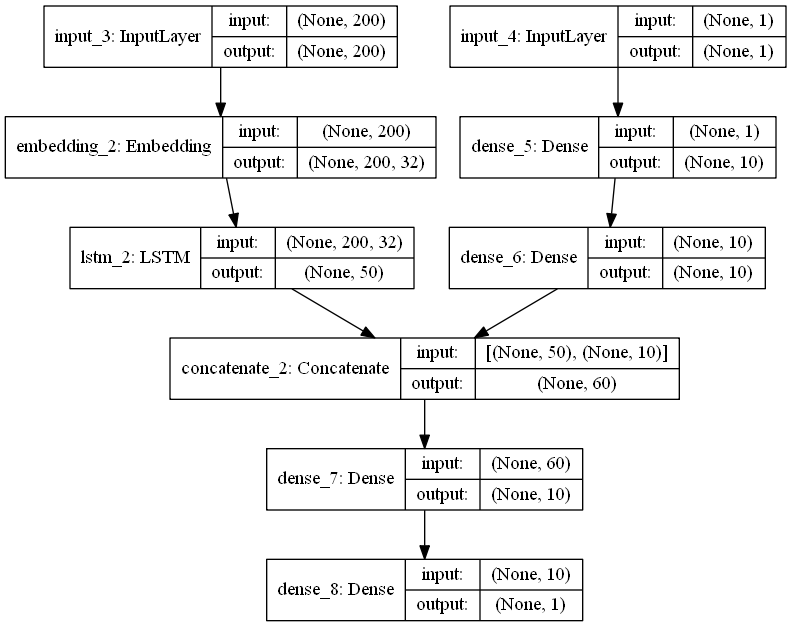

In [197]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot3.png', show_shapes=True, show_layer_names=True)

In [198]:
history = model.fit(x = [X1_train, X2_train], y = y_train, batch_size = 128, epochs = 10, verbose = 1, validation_split=0.2)

Train on 7385 samples, validate on 1847 samples
Epoch 1/10
7385/7385 [==============================] - 12s 2ms/step - loss: 0.5461 - accuracy: 0.7951 - val_loss: 0.4861 - val_accuracy: 0.7818
Epoch 2/10
7385/7385 [==============================] - 12s 2ms/step - loss: 0.4116 - accuracy: 0.7951 - val_loss: 0.3486 - val_accuracy: 0.7818
Epoch 3/10
7385/7385 [==============================] - 11s 2ms/step - loss: 0.2621 - accuracy: 0.8952 - val_loss: 0.1927 - val_accuracy: 0.9280
Epoch 4/10
7385/7385 [==============================] - 11s 2ms/step - loss: 0.1446 - accuracy: 0.9437 - val_loss: 0.1102 - val_accuracy: 1.0000
Epoch 5/10
7385/7385 [==============================] - 11s 2ms/step - loss: 0.0872 - accuracy: 0.9802 - val_loss: 0.0676 - val_accuracy: 1.0000
Epoch 6/10
7385/7385 [==============================] - 11s 2ms/step - loss: 0.0517 - accuracy: 1.0000 - val_loss: 0.0401 - val_accuracy: 1.0000
Epoch 7/10
7385/7385 [==============================] - 11s 1ms/step - loss: 0.030

In [199]:
score = model.evaluate(x=[X1_test, X2_test], y=y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

2309/2309 [==============================] - 2s 774us/step
Test Score: 0.006780624746205023
Test Accuracy: 1.0


In [200]:
# Save model to disk
model_name = 'D:\\Study\\DataScience\\Projects\\AI-Advertising\\SentimentAnalysis\\customer_sentiment_MultiInput.h5'

model.save(model_name)

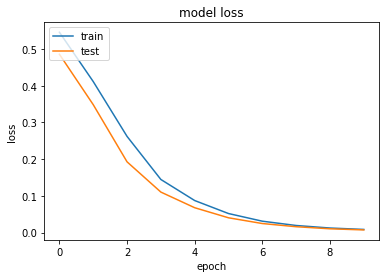

In [201]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [251]:
# Load a compiled model
from keras.models import load_model

sentiment_model = load_model(model_name)

In [253]:
test_review = "It's a really big bad thing."
test_star = [1]


tw = tokenizer.texts_to_sequences([test_review])
tw = pad_sequences(tw, padding='post', maxlen=maxlen)

arr = np.array(test_star)

prediction = int(sentiment_model.predict([tw, arr]).round().item())

sentiment = label_encoder.inverse_transform([prediction])[0]

# Print the sentiment
print('This is a {} sentiment.'.format(sentiment))

This is a negative sentiment.
